C:\Users\20529\AppData\Local\Temp\ipykernel_7472\1555615215.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x=df.columns[0], y=df.columns[1], data=df, linewidth=2, fliersize=4, palette=palette, zorder=2)
C:\Users\20529\AppData\Local\Temp\ipykernel_7472\1555615215.py:23: UserWarning: 
The palette list has fewer values (8) than needed (26) and will cycle, which may produce an uninterpretable plot.
  box_plot = sns.boxplot(x=df.columns[0], y=df.columns[1], data=df, linewidth=2, fliersize=4, palette=palette, zorder=2)
C:\Users\20529\AppData\Local\Temp\ipykernel_7472\1555615215.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  violin_plot = sns.violinplot(x=df.columns[0], y=df.columns[1]

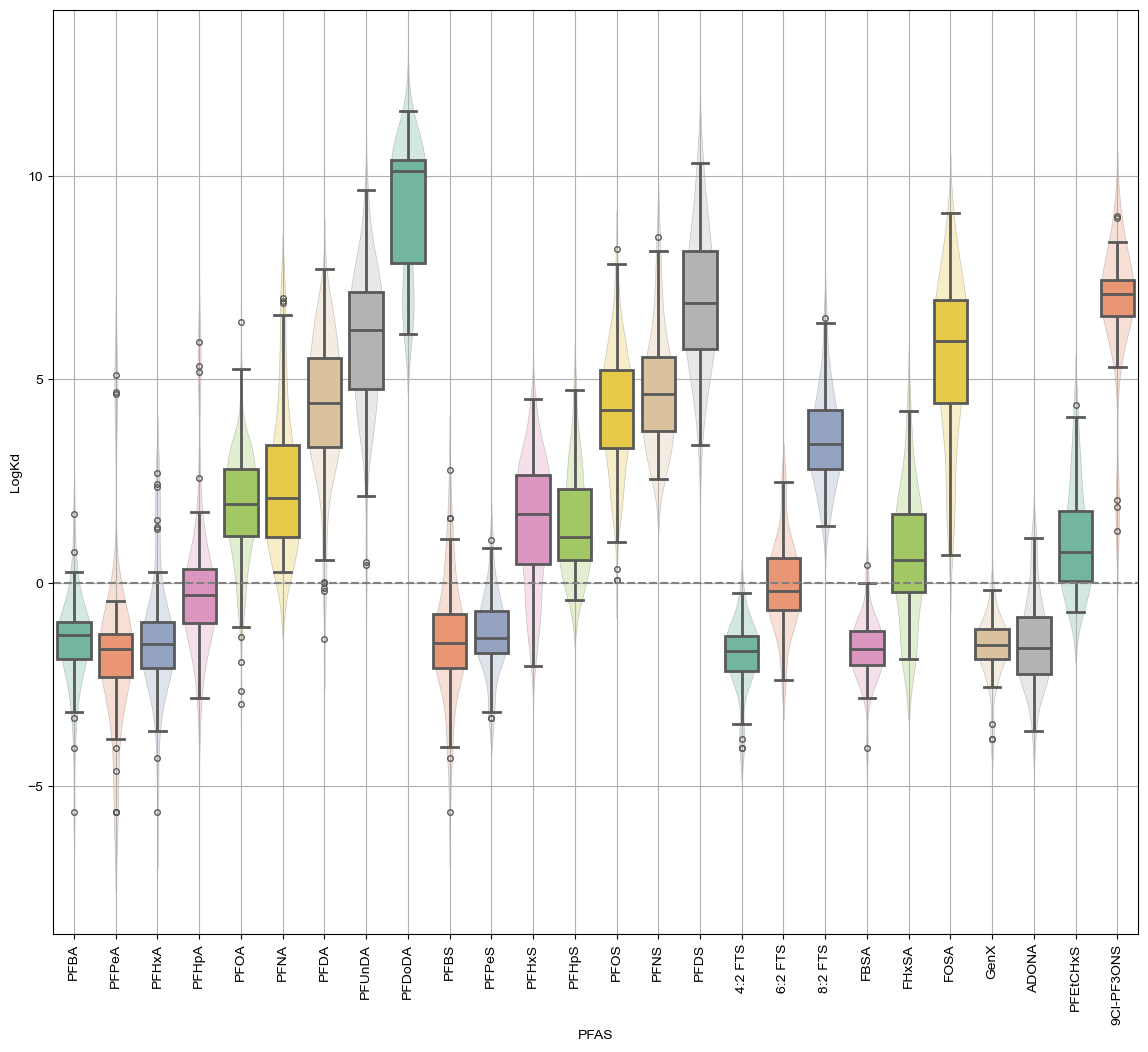

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set global parameters for plotting
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
palette = sns.color_palette("Set2")

# Read data
df = pd.read_excel('../data/data-3.xlsx')

# Caculate mean and standard deviation
mean = df.iloc[:, 1].mean()
std = df.iloc[:, 1].std()

# Remove outliers
df = df[(df.iloc[:, 1] > mean - 3*std) & (df.iloc[:, 1] < mean + 3*std)].dropna()

# Visualize data distribution with boxplot and violinplot
plt.figure(figsize=(14, 12))
box_plot = sns.boxplot(x=df.columns[0], y=df.columns[1], data=df, linewidth=2, fliersize=4, palette=palette, zorder=2)
violin_plot = sns.violinplot(x=df.columns[0], y=df.columns[1], data=df, linewidth=0.5, inner=None, 
                              palette=palette, alpha=0.3, zorder=1)

plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=90)
plt.grid(True)

plt.savefig('../figures/Boxplot_of_LogKd.svg', dpi=300, format='svg')
plt.show()

In [2]:
import numpy as np
import pandas as pd
from math import sqrt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Read data
data = pd.read_excel('../data/data-3.xlsx')

# Separate features and target variable
X = data.drop(['PFAS', 'LogKd'], axis=1)
y = data['LogKd']

# Split dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

final_models = {}

# Define models and hyperparameter spaces
model_spaces = {

    'GBRT': {'model': GradientBoostingRegressor,'params': {
            'n_estimators': hp.choice('gbrt_n_estimators', range(100, 1001)),
            'learning_rate': hp.loguniform('gbrt_learning_rate', np.log(0.01), np.log(0.3)),
            'max_depth': hp.choice('gbrt_max_depth', range(1, 11)),
            'min_samples_split': hp.uniform('gbrt_min_samples_split', 0.1, 1.0),
            'min_samples_leaf': hp.uniform('gbrt_min_samples_leaf', 0.1, 0.5)}},

    'RF': {'model': RandomForestRegressor,'params': {
            'n_estimators': hp.choice('rf_n_estimators', range(100, 1001)),
            'max_depth': hp.choice('rf_max_depth', range(1, 21)),
            'min_samples_split': hp.choice('rf_min_samples_split', range(2, 11)),
            'min_samples_leaf': hp.choice('rf_min_samples_leaf', range(1, 11)),
            'max_features': hp.choice('rf_max_features', ['sqrt', 'log2', None]),
            'bootstrap': hp.choice('rf_bootstrap', [True, False])}},

    'KNN':{'model': KNeighborsRegressor,'params': {
        'n_neighbors': hp.choice('knn_n_neighbors', range(1, 31)),
        'weights': hp.choice('knn_weights', ['uniform', 'distance']),
        'algorithm': hp.choice('knn_algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': hp.choice('knn_leaf_size', range(1, 50)),
        'p': hp.choice('knn_p', [1, 2]) 
    }}, 

    'MLR': {'model': LinearRegression, 'params': {'fit_intercept': hp.choice('mlr_fit_intercept', [True, False])}}}

# Define the objective function
def objective(params, model, X, y):
    reg = model(**params)
    kf = KFold(n_splits=5)
    scores = cross_val_score(reg, X, y, cv=kf, scoring='neg_mean_squared_error')
    return {'loss': -np.mean(scores), 'status': STATUS_OK}

# Otimize
for model_name, space in model_spaces.items():
    print(f"Optimizing {model_name}")
    trials = Trials()
    best = fmin(fn=lambda params: objective(params, space['model'], X_train_full, y_train_full),
                space=space['params'], algo=tpe.suggest, max_evals=50, trials=trials,rstate=np.random.default_rng(42))
    
    best_params = space_eval(space['params'], best)
    print(f"Best params for {model_name}: {best_params}")
    
    # Use the best parameters to evaluate the model on the test set
    model = space['model'](**best_params)
    
    model.fit(X_train_full, y_train_full)
    y_pred = model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred)) 
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} on test set - RMSE: {rmse}, MAE: {mae}, R^2: {r2}\n")

    # Train the final model with the best parameters on the full training set
    model = space['model'](**best_params)
    model.fit(X_train_full, y_train_full)
    
    # Save the final model
    final_models[model_name] = model

Optimizing GBRT
100%|██████████| 50/50 [01:56<00:00,  2.33s/trial, best loss: 1.0189646845709501]
Best params for GBRT: {'learning_rate': 0.07761833308846404, 'max_depth': 6, 'min_samples_leaf': 0.10171872147425852, 'min_samples_split': 0.11066771511218385, 'n_estimators': 284}
GBRT on test set - RMSE: 1.0395096206332395, MAE: 0.7181121424049216, R^2: 0.8970351829130714

Optimizing RF
100%|██████████| 50/50 [03:24<00:00,  4.08s/trial, best loss: 0.8150753387956348]
Best params for RF: {'bootstrap': False, 'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 626}
RF on test set - RMSE: 0.8549452127928105, MAE: 0.5818085975496088, R^2: 0.9303520407219747

Optimizing KNN
100%|██████████| 50/50 [00:02<00:00, 24.35trial/s, best loss: 1.2300851700299864]
Best params for KNN: {'algorithm': 'auto', 'leaf_size': 26, 'n_neighbors': 4, 'p': 2, 'weights': 'distance'}
KNN on test set - RMSE: 1.116589534824627, MAE: 0.7564122617546284, R^2: 0.881199

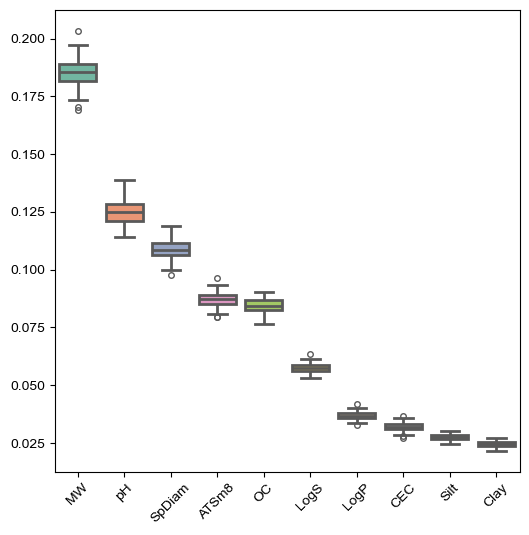

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict

# Fitting the model with the best parameters on the full training set
rf_model = final_models['RF']
rf_model.fit(X_train_full, y_train_full)

# Performing cross-validation and permutation importance
y_pred = cross_val_predict(rf_model, X_train_full, y_train_full, cv=5)

# Caculate permutation importance
n_repeats = 100
perm_importance = permutation_importance(rf_model, X_train_full, y_train_full, n_repeats=n_repeats, random_state=42)

# Extract feature names and importance scores
feature_names = X_train_full.columns
feature_importance = perm_importance.importances
average_importance = np.mean(feature_importance, axis=1)

# Select the top 10 most important features
top_indices = np.argsort(average_importance)[-10:][::-1]
top_feature_names = feature_names[top_indices]

df_perm_importance = pd.DataFrame(feature_importance[top_indices, :].T, columns=top_feature_names)

# Plot the permutation importance
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_perm_importance, linewidth=2, fliersize=4, palette="Set2")
plt.xticks(rotation=45)

plt.savefig('../figures/PFI.svg', dpi=300, format='svg')
plt.show()

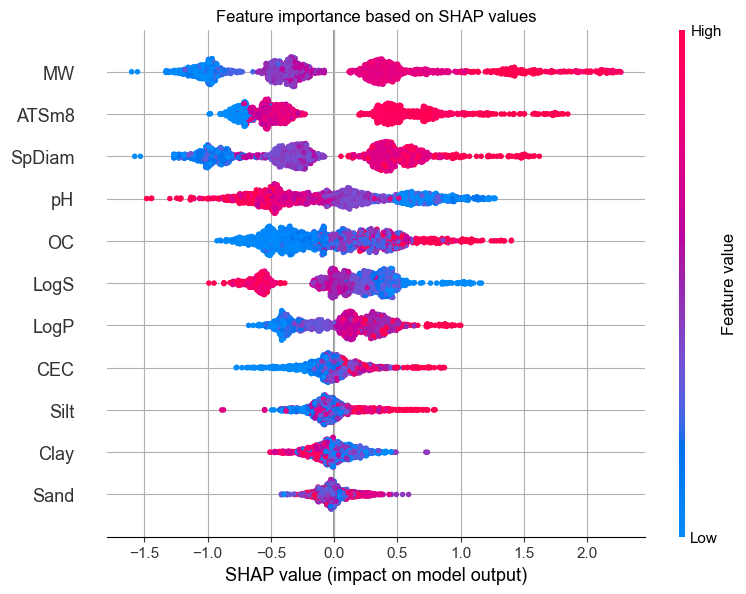

In [4]:
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_full.columns)

rf_model = final_models['RF']
rf_model.fit(X_train_scaled_df, y_train_full)

# Calculate SHAP values
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_train_scaled_df)

# Plot the summary plot
plt.figure(figsize=(6, 6))
shap.summary_plot(shap_values, X_train_scaled_df, plot_type="dot", show=False)

# Modify the plot
plt.title("Feature importance based on SHAP values")
plt.grid(True)
plt.savefig('../figures/Shap.svg', dpi=300, format='svg')
plt.show()

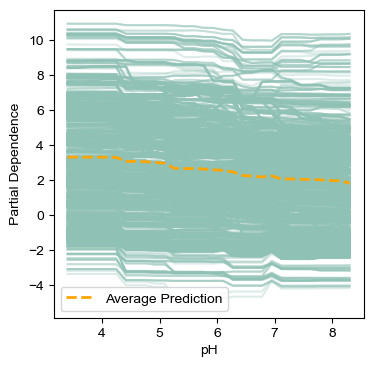

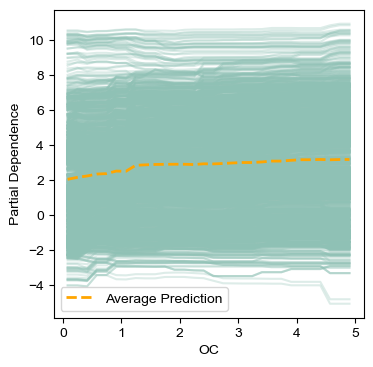

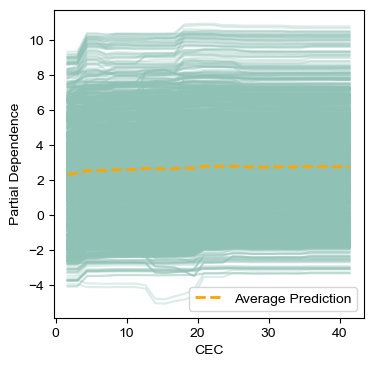

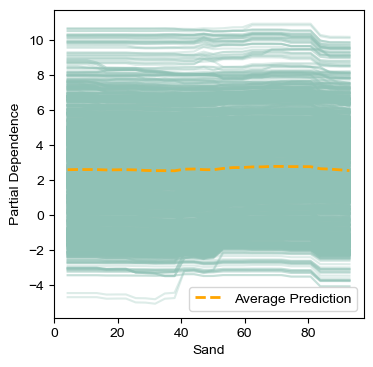

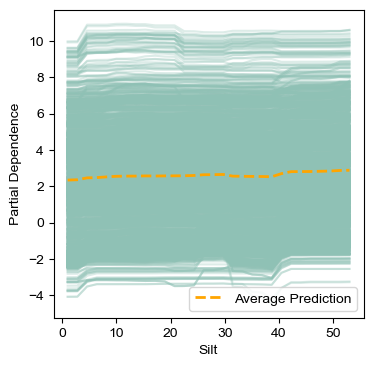

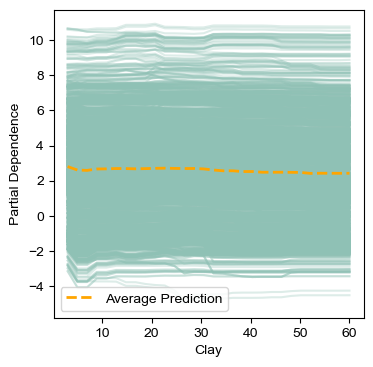

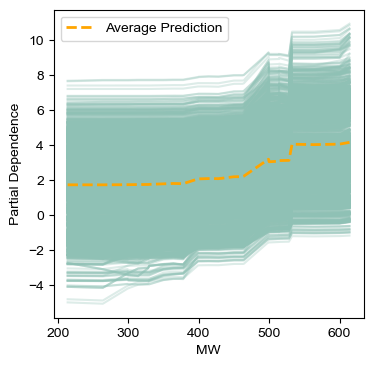

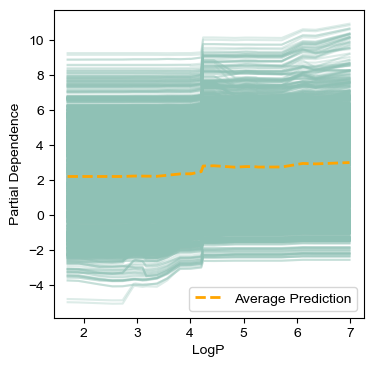

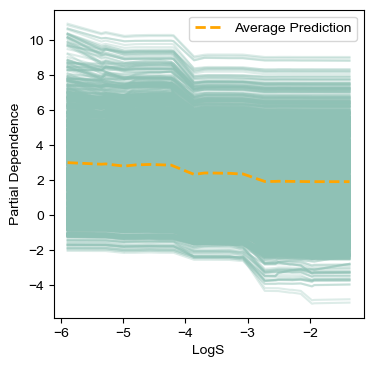

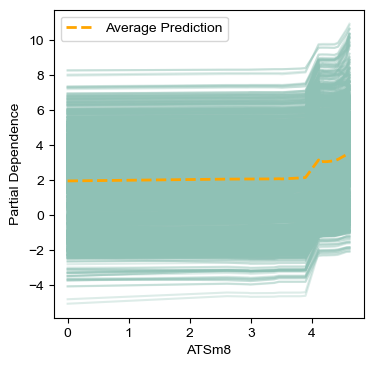

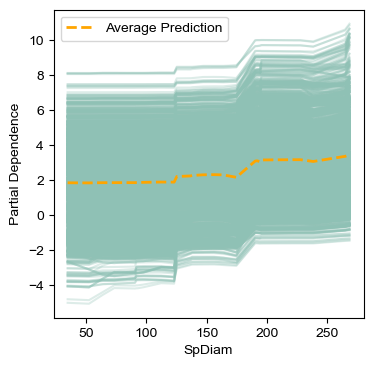

In [5]:
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence

# Color settings
custom_palette = ['#8FC1B5']
center_line_color = 'orange'

image_counter = 1
rf_model.fit(X_train_full, y_train_full)

# Plot the ICE curves
def plot_ice_and_cice(model, X, feature, feature_name,counter):
    global image_counter
    pd_results = partial_dependence(model, X, [feature], kind="both", grid_resolution=30)
    feature_values = pd_results['grid_values'][0]
    individual_predictions = pd_results['individual'][0]

    plt.figure(figsize=(4, 4))
    for instance_preds in individual_predictions:
        plt.plot(feature_values, instance_preds, color=custom_palette[0], alpha=0.3)
    plt.plot(feature_values, pd_results['average'][0], color=center_line_color, linewidth=2, linestyle='--', label='Average Prediction')
    plt.xlabel(f'{feature_name}')
    plt.ylabel('Partial Dependence')
    plt.legend()

    # Save the figure
    plt.savefig(f'../figures/ICE_{counter}.svg', dpi=300, format='svg')
    plt.show()
    image_counter += 1

# Plot ICE curves for each feature and save the figures
for feature in X_train_full.columns:
    plot_ice_and_cice(rf_model, X_train_full, feature, feature, image_counter)

<Figure size 400x400 with 0 Axes>

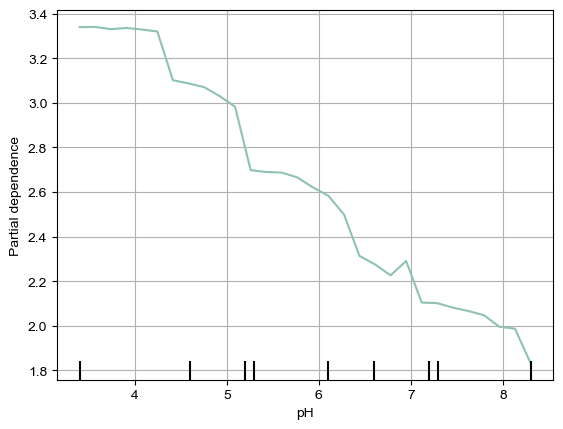

<Figure size 400x400 with 0 Axes>

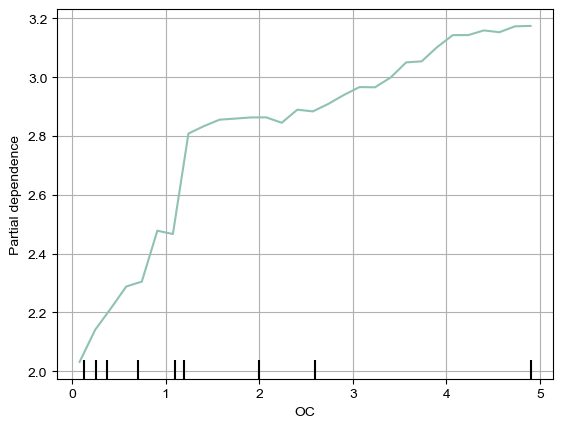

<Figure size 400x400 with 0 Axes>

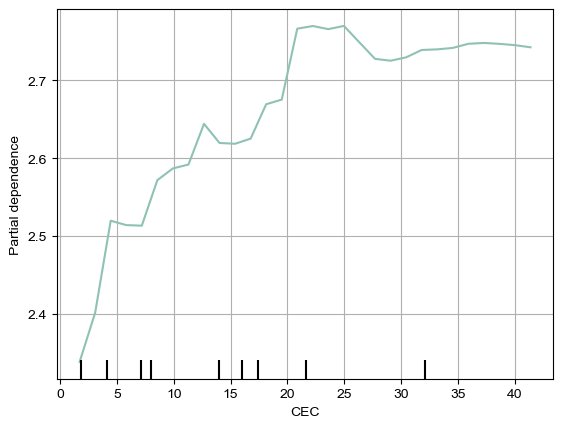

<Figure size 400x400 with 0 Axes>

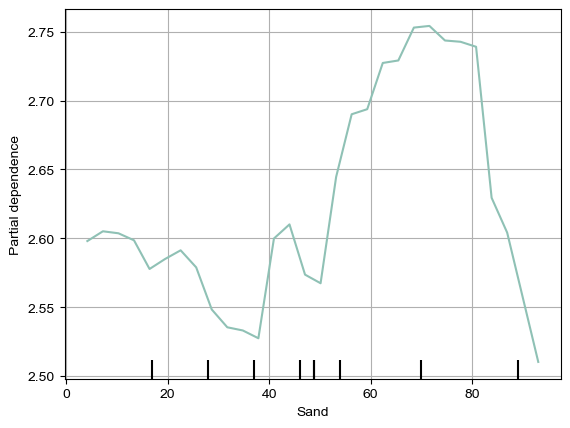

<Figure size 400x400 with 0 Axes>

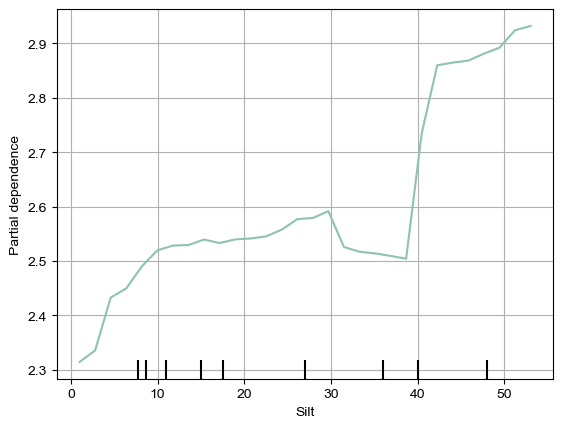

<Figure size 400x400 with 0 Axes>

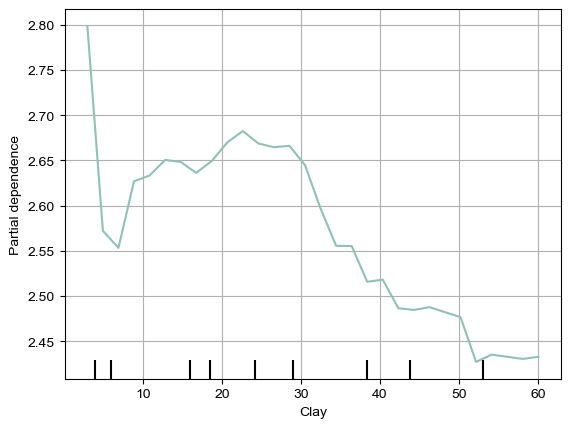

<Figure size 400x400 with 0 Axes>

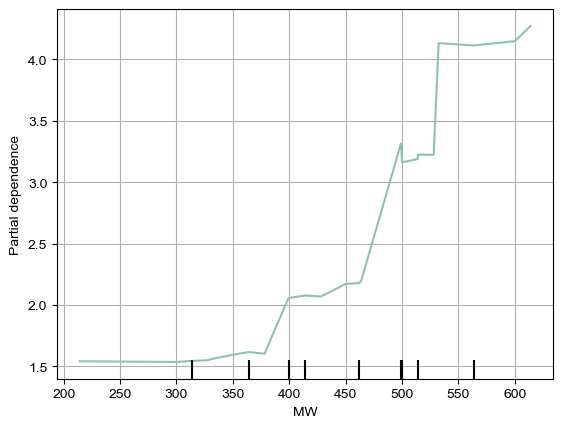

<Figure size 400x400 with 0 Axes>

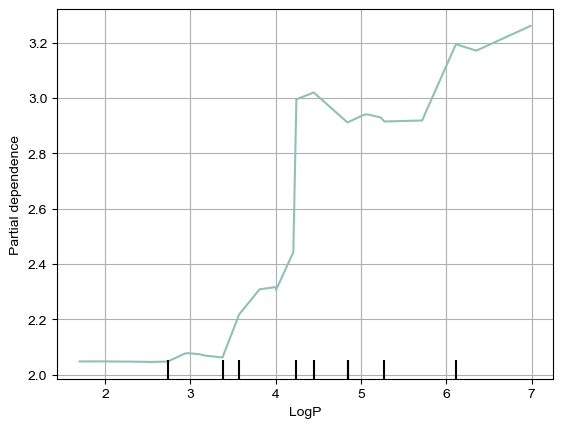

<Figure size 400x400 with 0 Axes>

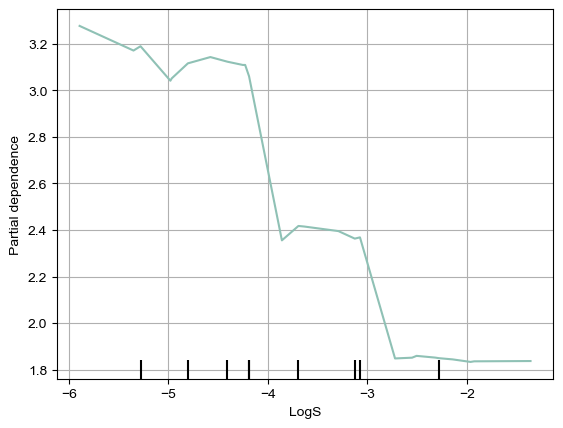

<Figure size 400x400 with 0 Axes>

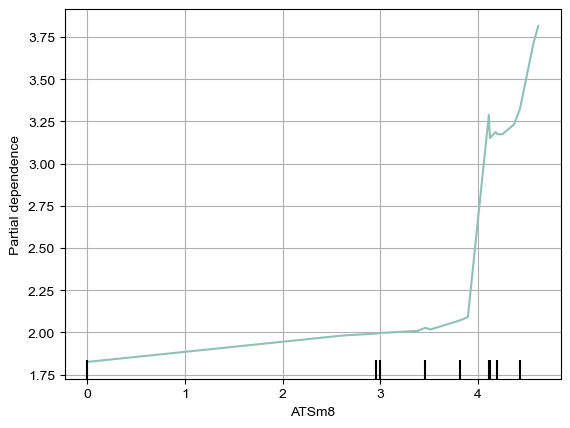

<Figure size 400x400 with 0 Axes>

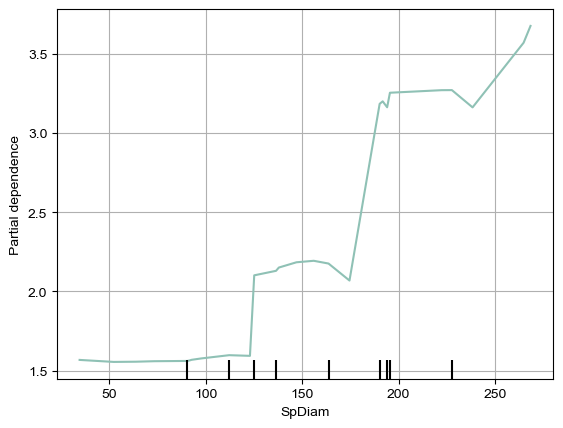

In [6]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

# Settings
custom_palette = ['#8FC1B5']

# Set grid resolution
grid_resolution = 30

# Initiate counter
counter = 1

# Plot PDP for each feature
for feature in X_train_full.columns:
    plt.figure(figsize=(4,4))  

    # Create PartialDependenceDisplay object
    display = PartialDependenceDisplay.from_estimator(
        rf_model, X_train_full, features=[feature],
        grid_resolution=grid_resolution, percentiles=(0.05, 0.95),
        line_kw={"color": custom_palette[0]})

    plt.grid(True)
    
    # Save the figure and show
    plt.savefig(f'../figures/PDP_{counter}.svg', dpi=300, format='svg')
    plt.show()

    counter += 1

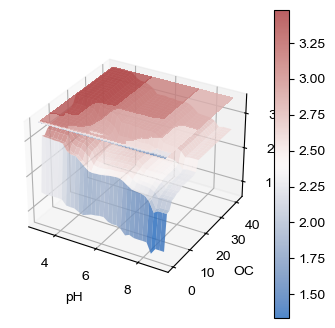

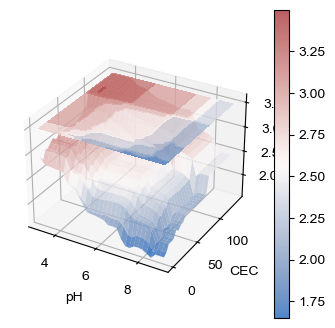

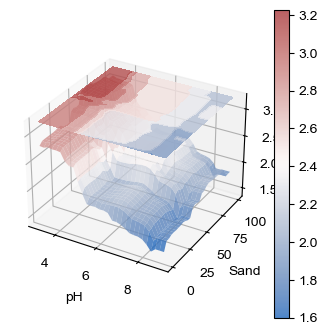

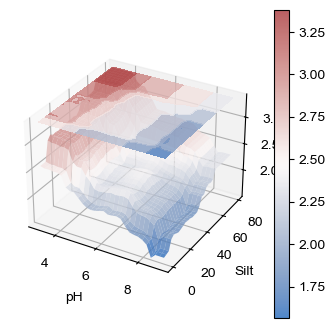

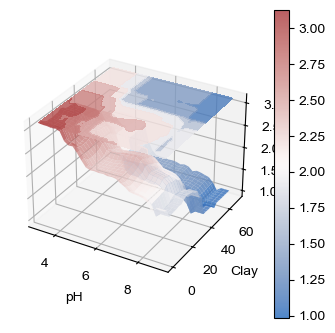

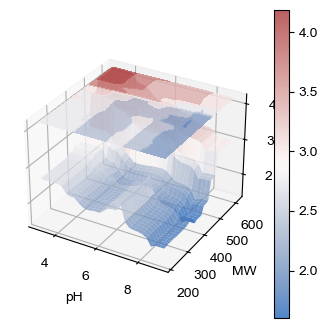

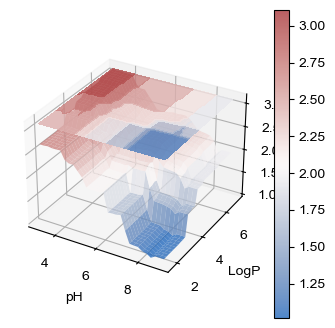

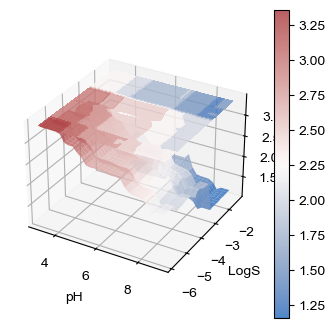

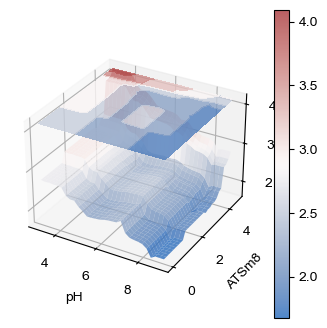

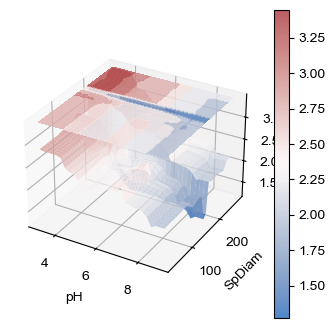

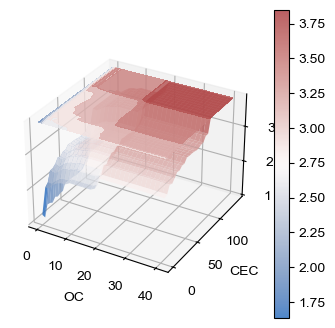

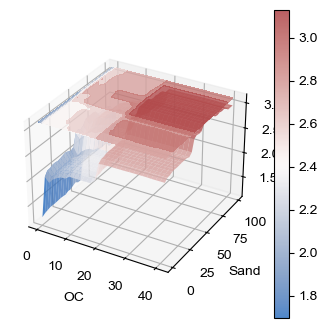

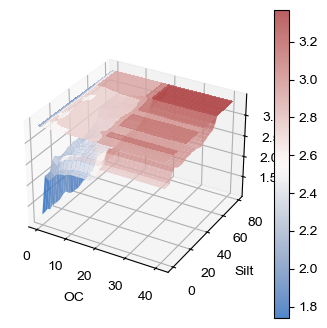

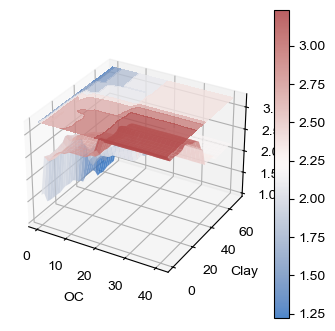

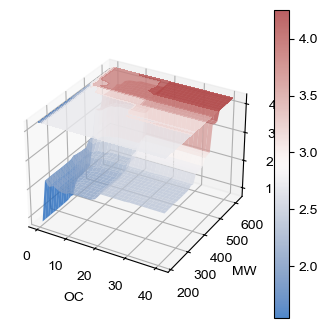

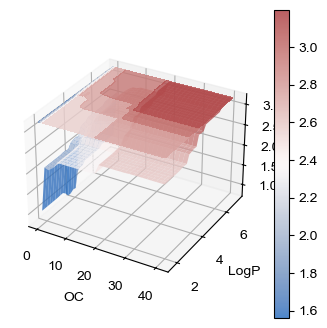

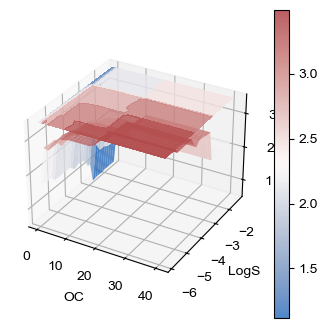

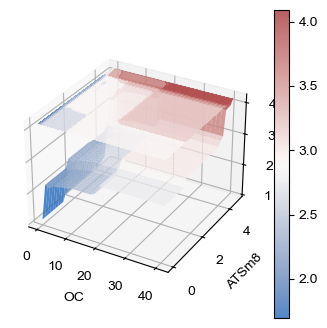

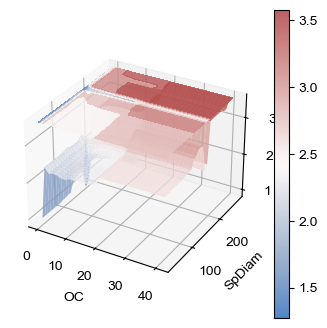

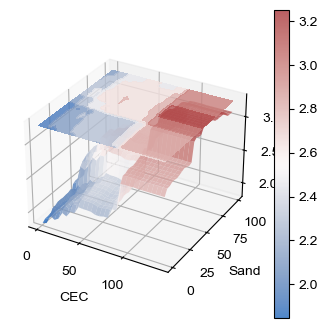

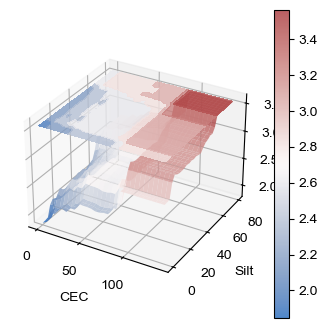

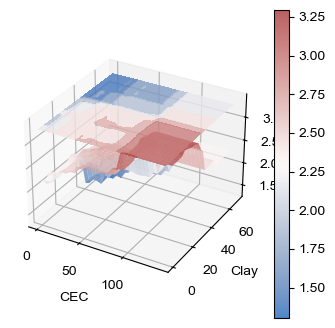

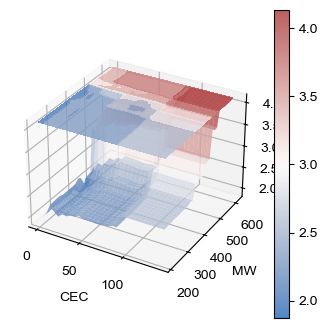

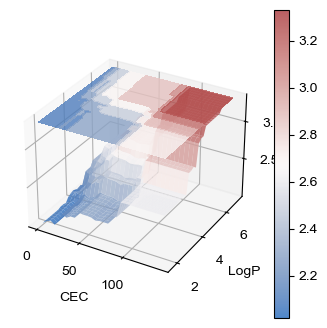

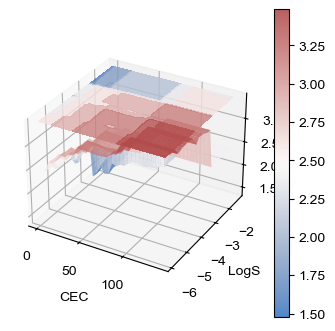

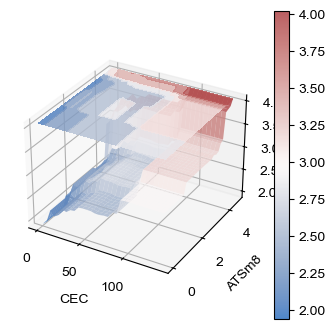

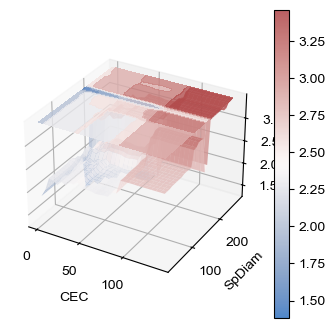

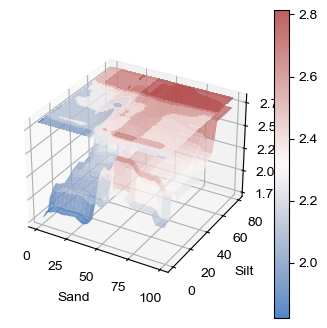

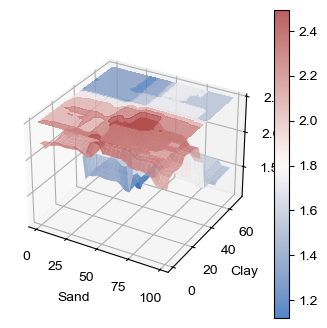

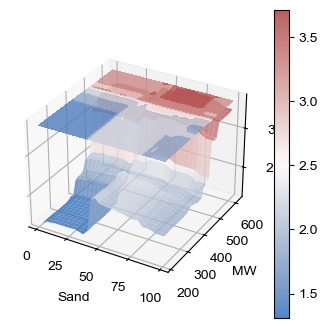

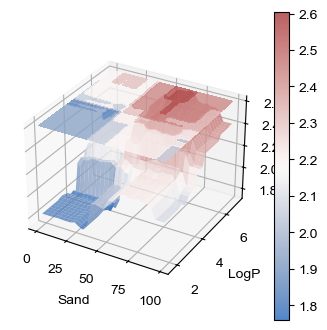

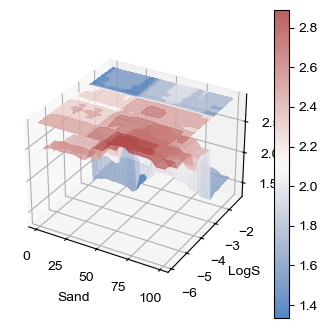

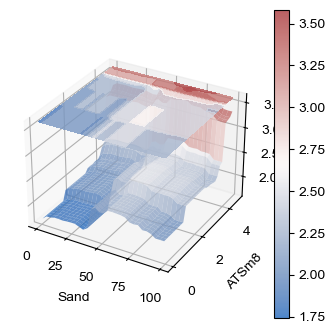

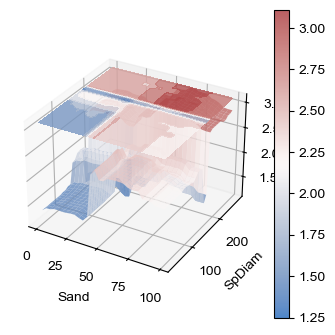

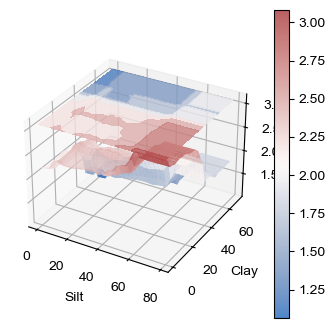

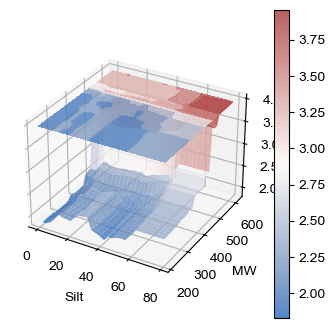

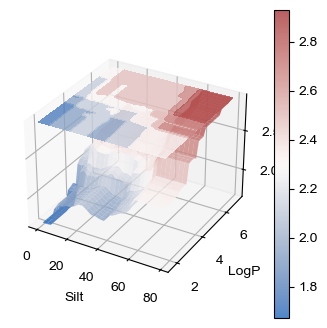

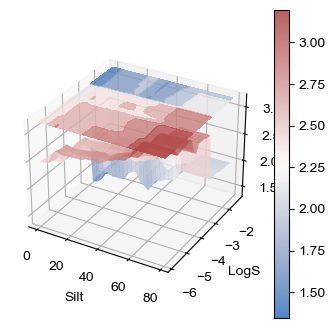

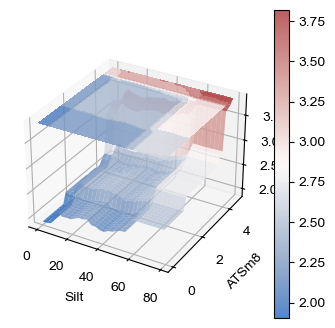

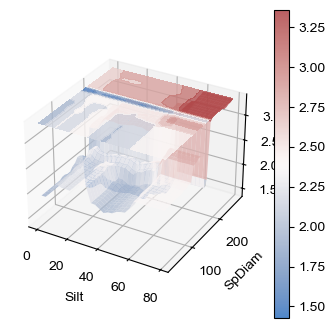

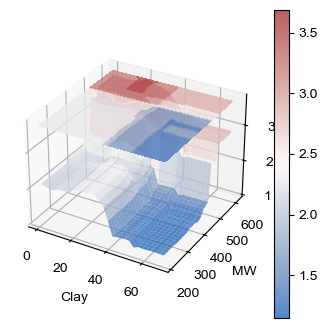

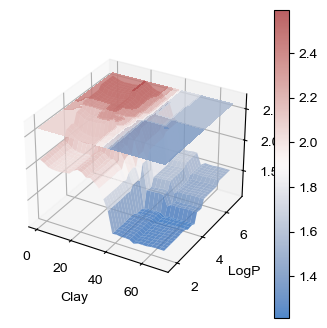

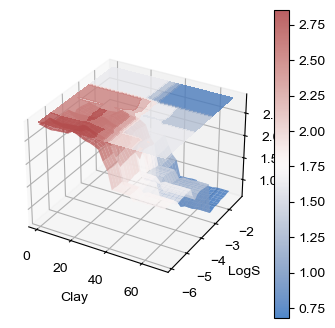

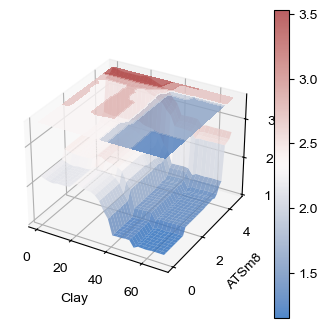

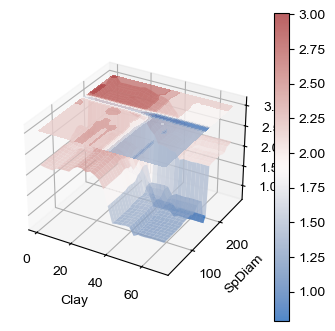

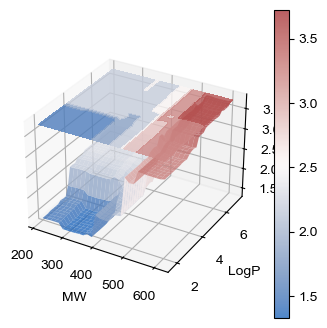

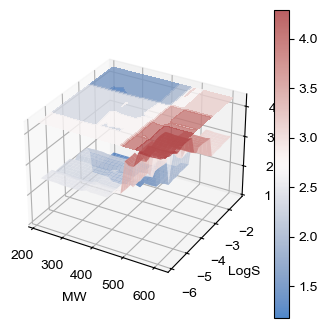

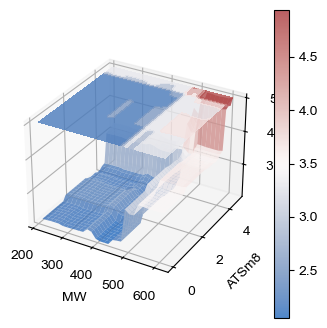

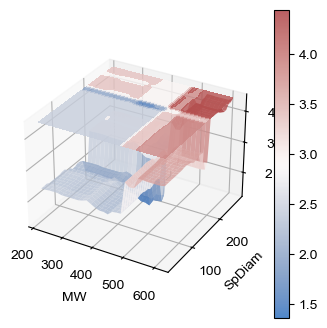

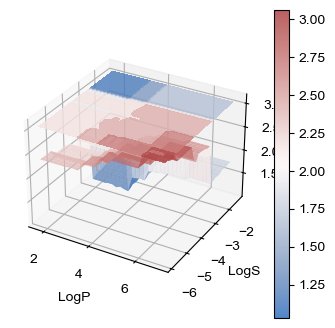

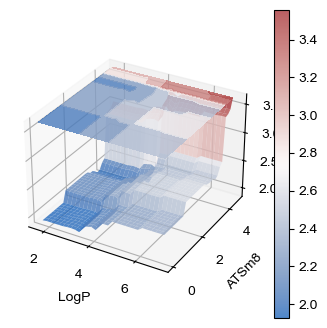

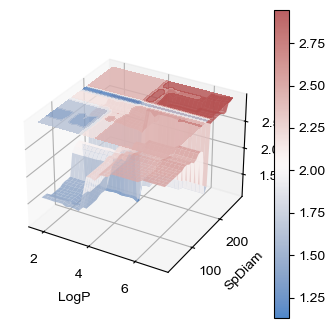

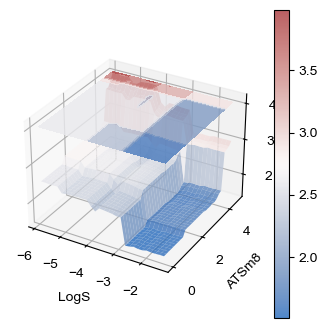

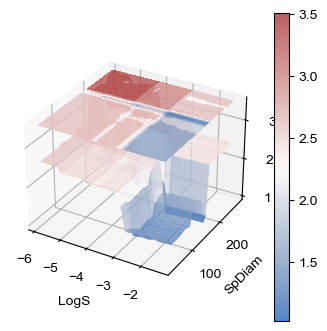

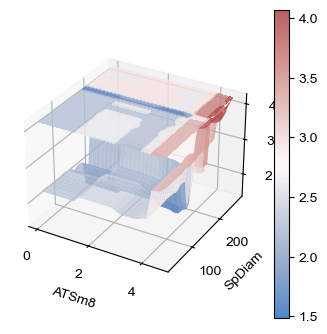

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.colors import LinearSegmentedColormap

image_counter = 1
cmap = sns.color_palette("vlag", as_cmap=True)

# Initialize the model and fit it to the training data
rf_model.fit(X_train_full, y_train_full)

# Plot 3D interaction plots with projections
def plot_3d_interaction_with_projection(feature1, feature2, model, X, grid_resolution, cmap, counter):
    global image_counter

    # Caculate feature values
    x_min, x_max = X[feature1].min(), X[feature1].max()
    y_min, y_max = X[feature2].min(), X[feature2].max()
    x_grid = np.linspace(x_min, x_max, grid_resolution)
    y_grid = np.linspace(y_min, y_max, grid_resolution)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

    grid_X = pd.DataFrame()
    for col in X.columns:
        if col == feature1:
            grid_X[col] = X_grid.ravel()
        elif col == feature2:
            grid_X[col] = Y_grid.ravel()
        else:
            grid_X[col] = np.repeat(X[col].mean(), grid_resolution**2)

    # Predict the values on the grid
    Z_grid = model.predict(grid_X).reshape(X_grid.shape)
      
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')

    # Plot 3D surface
    surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap=cmap, alpha=0.8)

    # Plot XY plane projection
    ax.contourf(X_grid, Y_grid, Z_grid, zdir='z', offset=Z_grid.max() , cmap=cmap, alpha=0.8)

    # Adjust plot
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)

    # Add colorbar
    fig.colorbar(surf, ax=ax)

    plt.savefig(f'../figures/3d_interaction_{image_counter}.svg', dpi=300, format='svg')
    plt.show()

    image_counter += 1

# Get all feature names
all_feature_names = X_train_full.columns.tolist()

# Define grid resolution
grid_resolution = 30

# Plot 3D interaction plots with projections for all pairs of features
for feature1, feature2 in combinations(all_feature_names, 2):
    plot_3d_interaction_with_projection(feature1, feature2, rf_model, X_train_full, grid_resolution, cmap, image_counter)

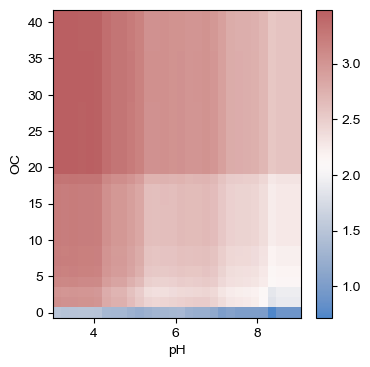

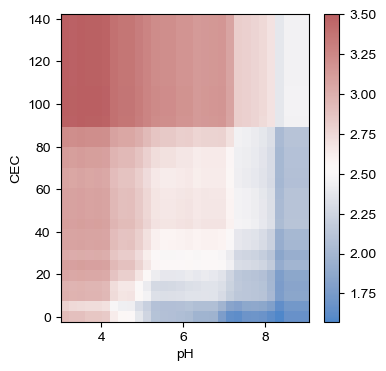

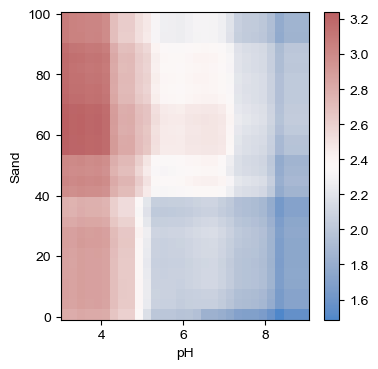

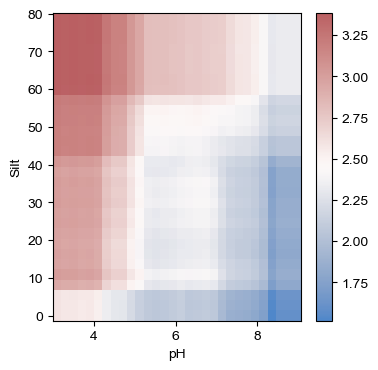

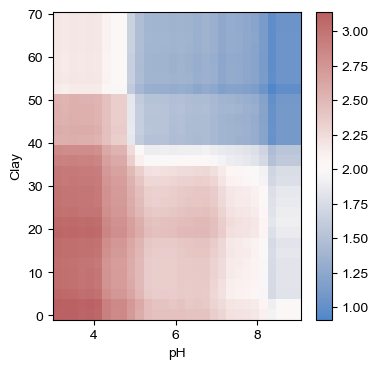

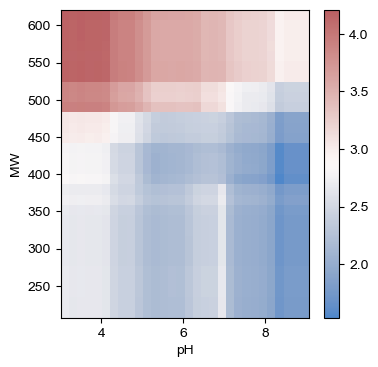

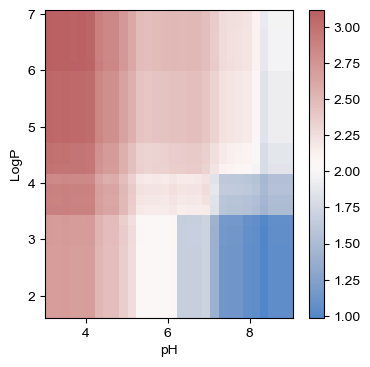

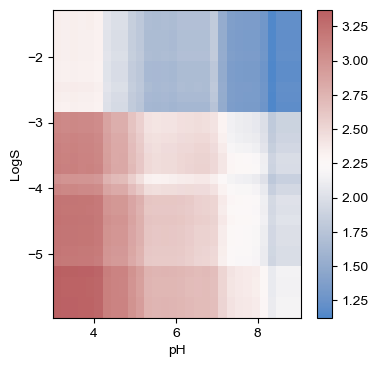

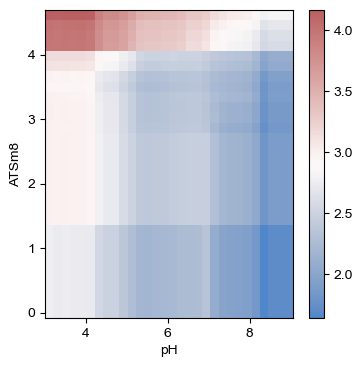

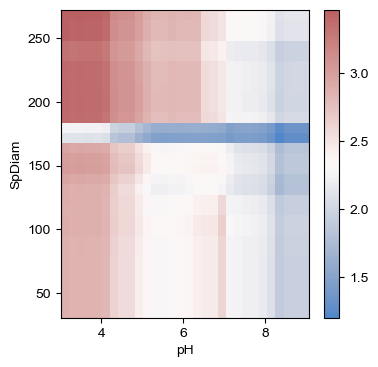

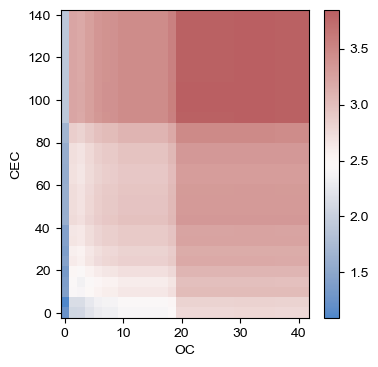

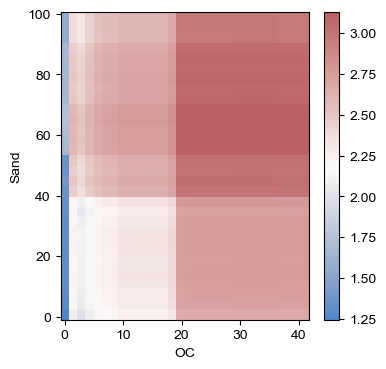

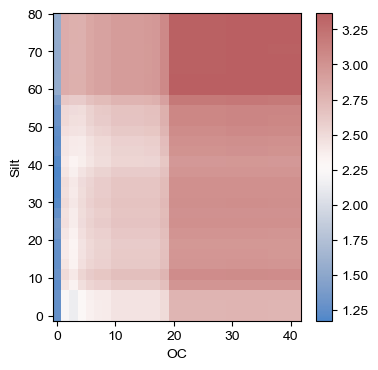

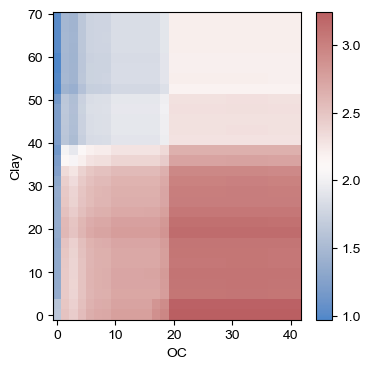

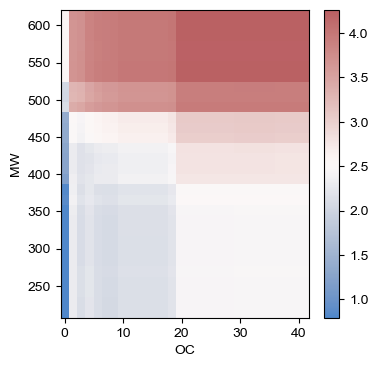

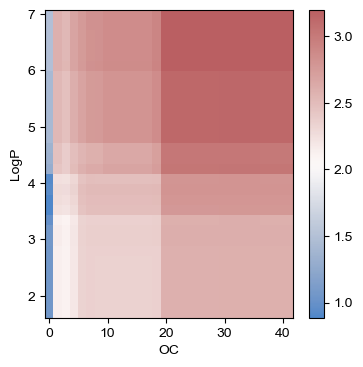

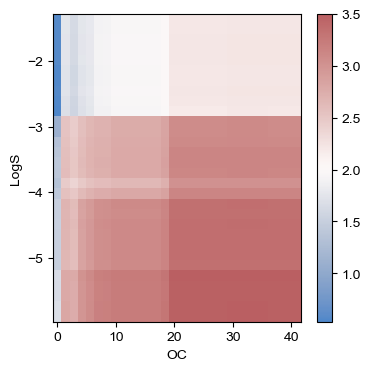

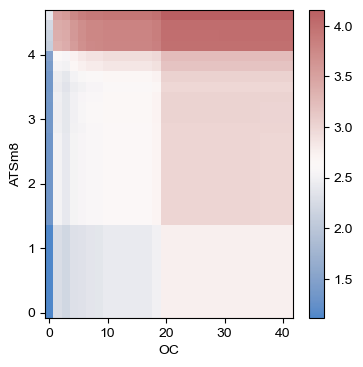

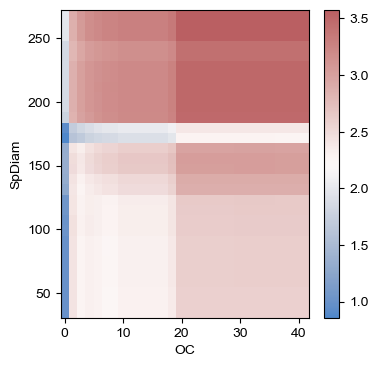

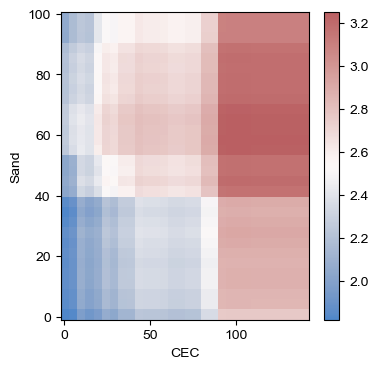

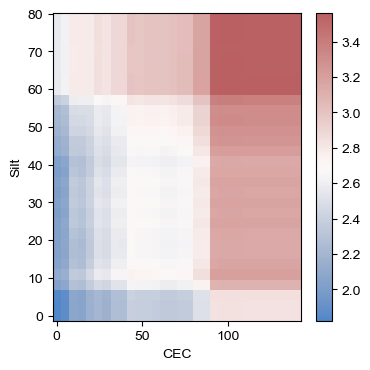

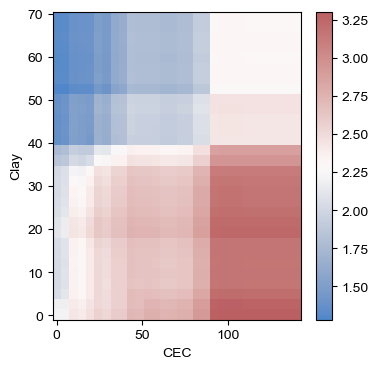

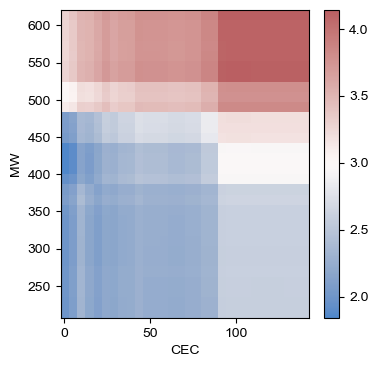

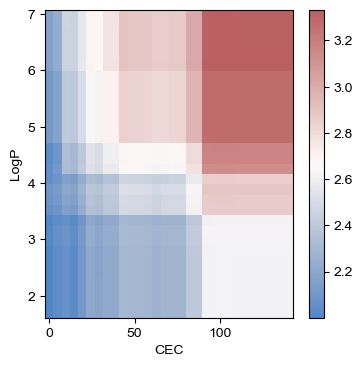

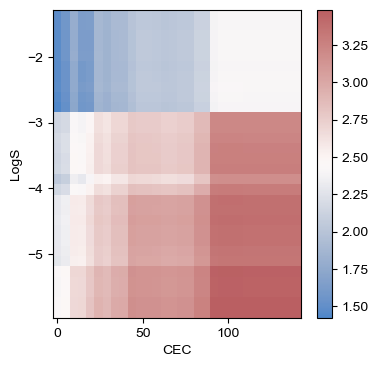

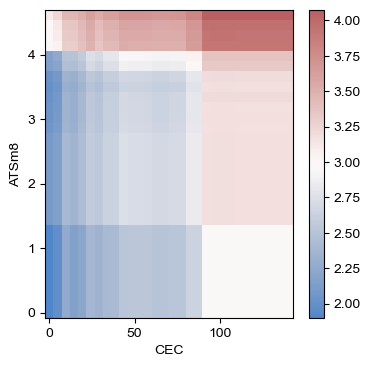

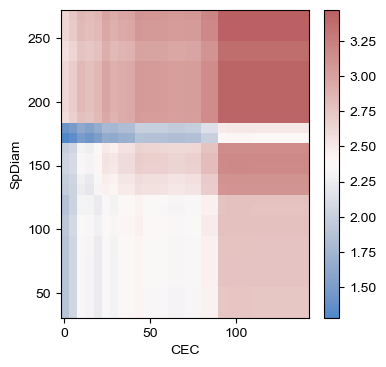

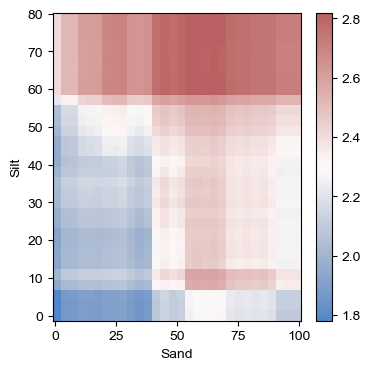

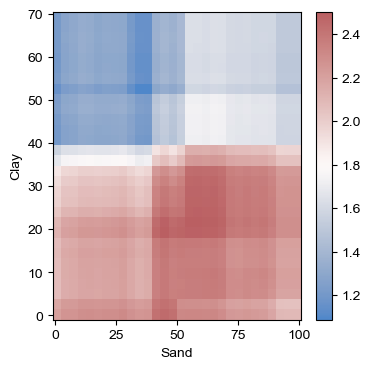

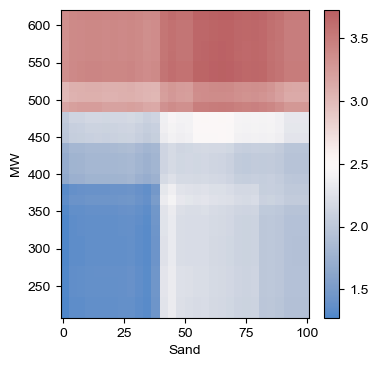

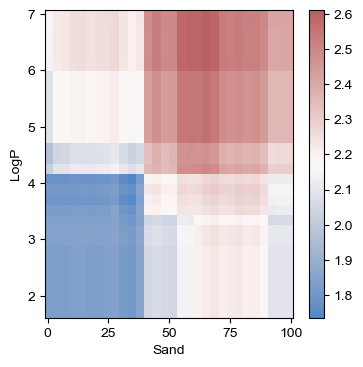

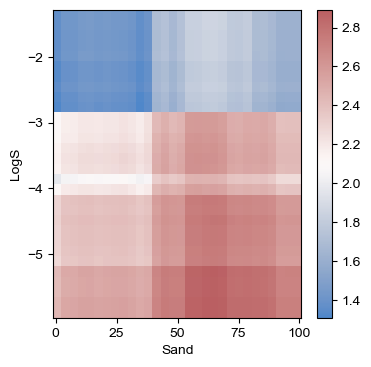

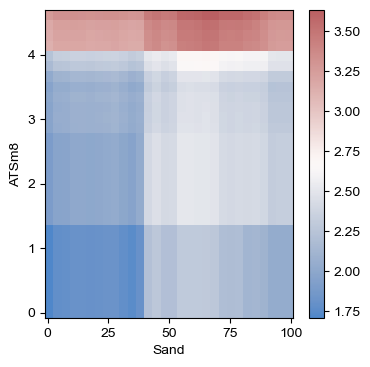

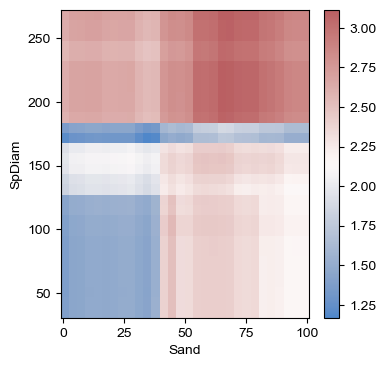

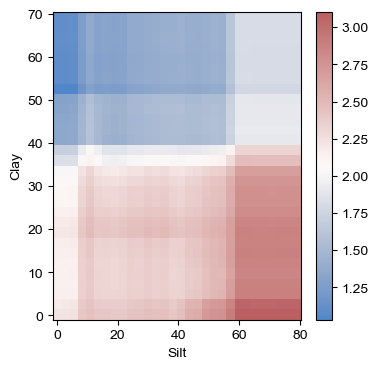

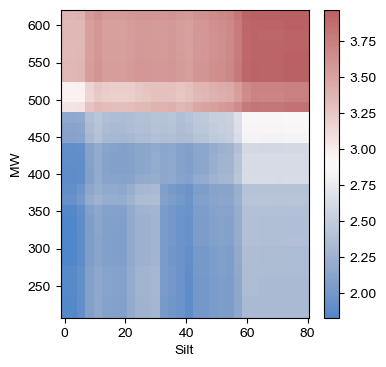

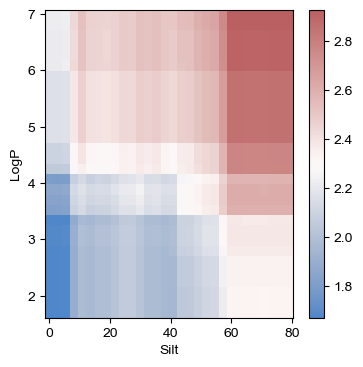

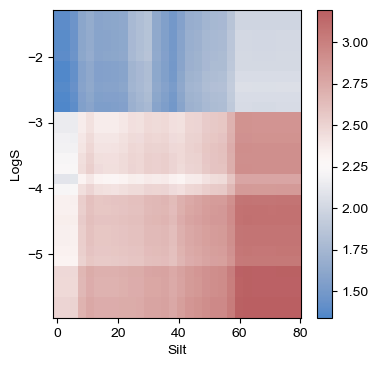

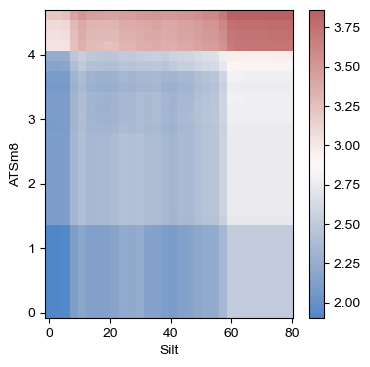

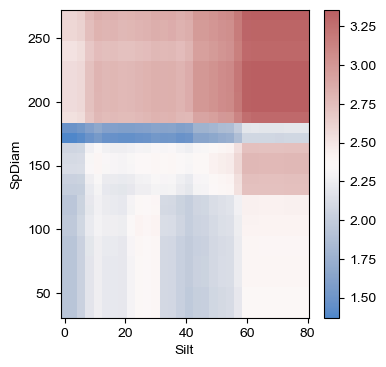

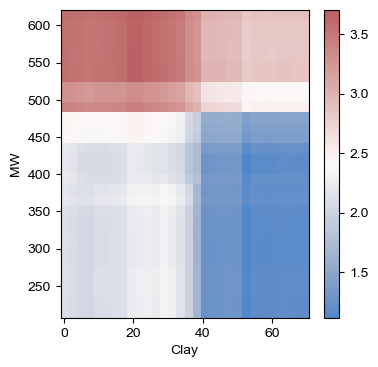

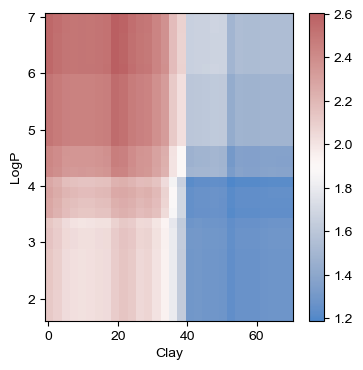

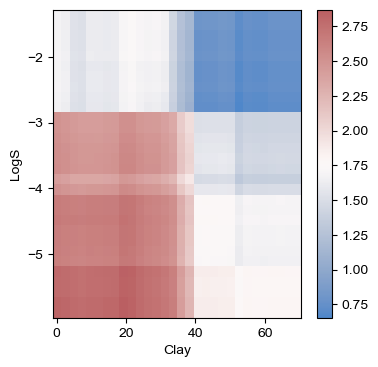

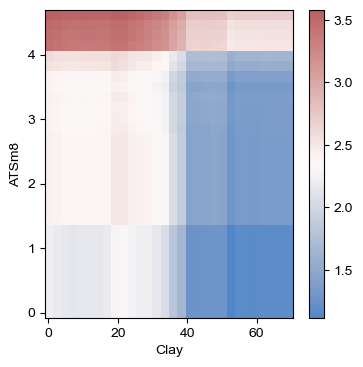

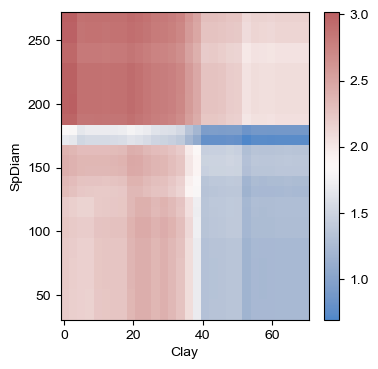

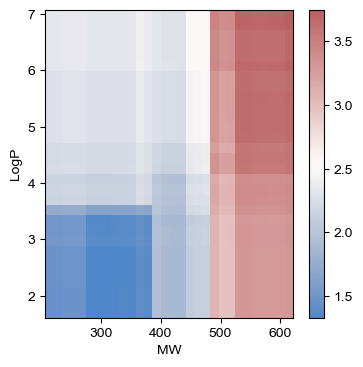

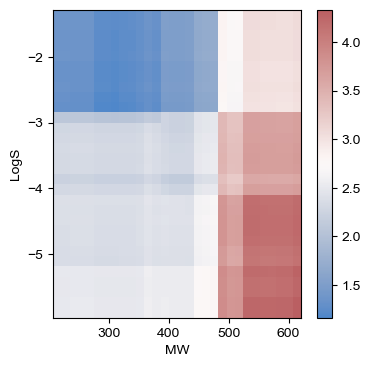

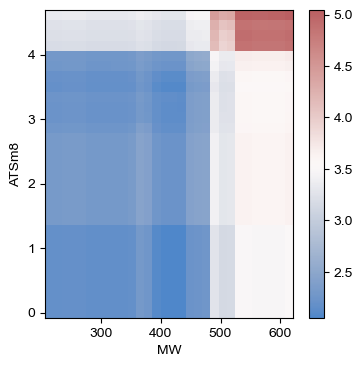

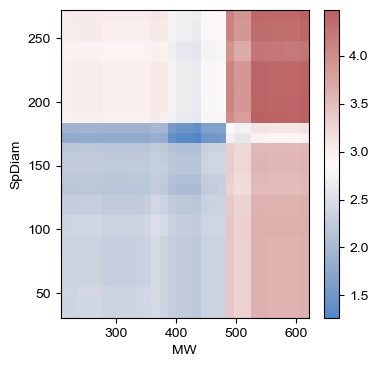

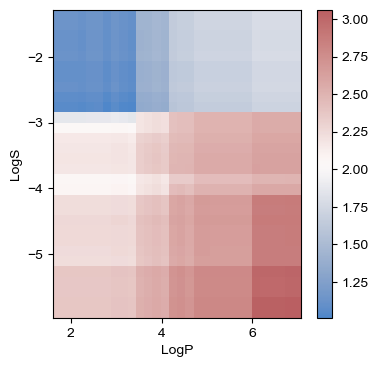

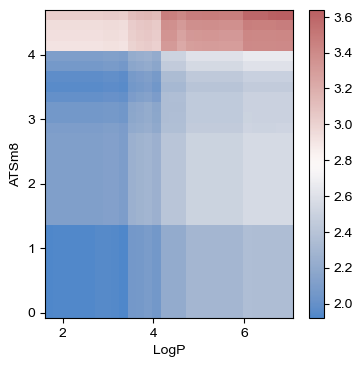

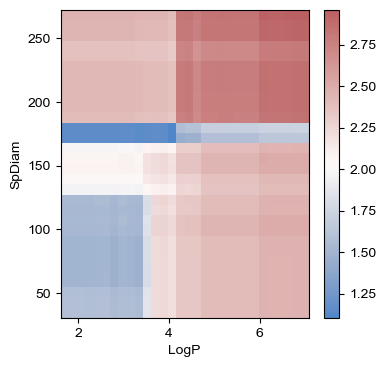

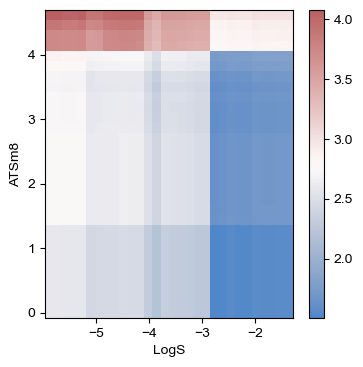

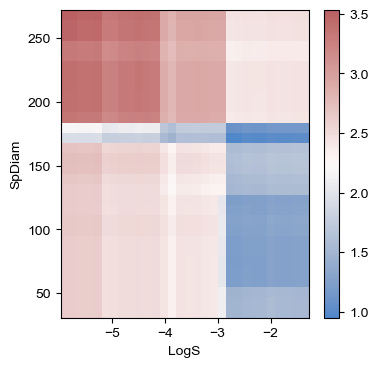

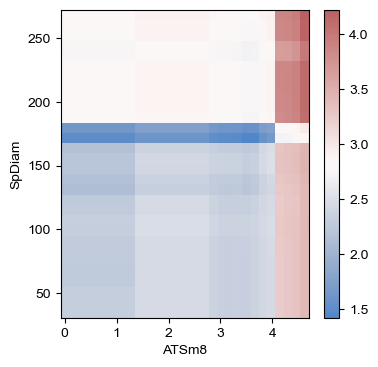

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import GradientBoostingRegressor

image_counter = 1
cmap = sns.color_palette("vlag", as_cmap=True)

# Plot 2D projection plots
def plot_2d_projection(feature1, feature2, model, X, grid_resolution, cmap,counter):
    global image_counter

    # Caculate feature values
    x_min, x_max = X[feature1].min(), X[feature1].max()
    y_min, y_max = X[feature2].min(), X[feature2].max()
    x_grid = np.linspace(x_min, x_max, grid_resolution)
    y_grid = np.linspace(y_min, y_max, grid_resolution)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

    grid_X = pd.DataFrame(columns=X.columns)
    grid_X[feature1] = X_grid.ravel()
    grid_X[feature2] = Y_grid.ravel()

    # Average values for other features
    for col in X.columns:
        if col not in [feature1, feature2]:
            grid_X[col] = np.repeat(X[col].mean(), grid_resolution**2)

 # Predict the values on the grid
    Z_grid = model.predict(grid_X).reshape(X_grid.shape)

    fig, ax = plt.subplots(figsize=(4, 4))
    mesh = ax.pcolormesh(X_grid, Y_grid, Z_grid, cmap=cmap,alpha=0.8)
    fig.colorbar(mesh, ax=ax)
    ax.set_xlabel(feature1)
    ax.set_ylabel(feature2)
    plt.grid(False)
    plt.savefig(f'../figures/2d_projection_{counter}.svg', dpi=300, format='svg')
    plt.show()
    image_counter += 1

# Get all feature names
all_feature_names = X_train_full.columns

# Plot 2D projection plots for all pairs of features
for feature1, feature2 in combinations(all_feature_names, 2):
    plot_2d_projection(feature1, feature2, rf_model, X_train_full, grid_resolution, cmap, image_counter)